In [ ]:
import sys

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
from torch import tensor
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import MNIST
from tqdm import tqdm

from lib.models.sparsity_loss import sparsity_loss_fn
from lib.utils.run_name import get_ae_run_name, get_clf_run_name
from lib.utils.image_tools import show_ims

# 2. Stacked Autoencoders

An *autoencoder* consists of two parts: an *encoder* and a *decoder*. We will be discussing autoencoders where the encoder, just like PCA, compresses a vector $x = (x_1, x_1,\ldots,x_m)$ to a lower-dimensional vector $z = (z_1,z_2,\ldots,z_n)$ with $n\lt m$. While PCA uses a linear mapping for this, the encoder of an autoencoder uses a more general mapping $f$ that is typically *nonlinear*:


$$
z = f(x).
$$

The second part of the autoencoder, the *decoder*, expands this compression back to the original dimensionality. This can be interpreted as a generalization of the reconstruction we did in the previous notebook. Let's say $g$ is the function used by the decoder, then

$$
\hat{x} = g(z) = g\left(f(x)\right).
$$

When training an autoencoder, the aim is to have $\hat{x}\approx x$. This can be done, for example, by **minimizing the reconstruction error**, i.e., finding the functions $f$ and $g$ such that $||\hat{x} - x||$ is minimized.

## 2.1 Employing Neural Networks for Building an Autoencoder

We will build an autoencoder using a neural network for the encoder and decoder. The network illustrated below uses a fully-connected layer to transform a 6-dimensional input vector ($x$) to a 3-dimensional encoding ($z$). The encoding is decoded by another fully-connected layer that transforms $z$ back to a 6-dimensional output vector ($\hat{x}$).

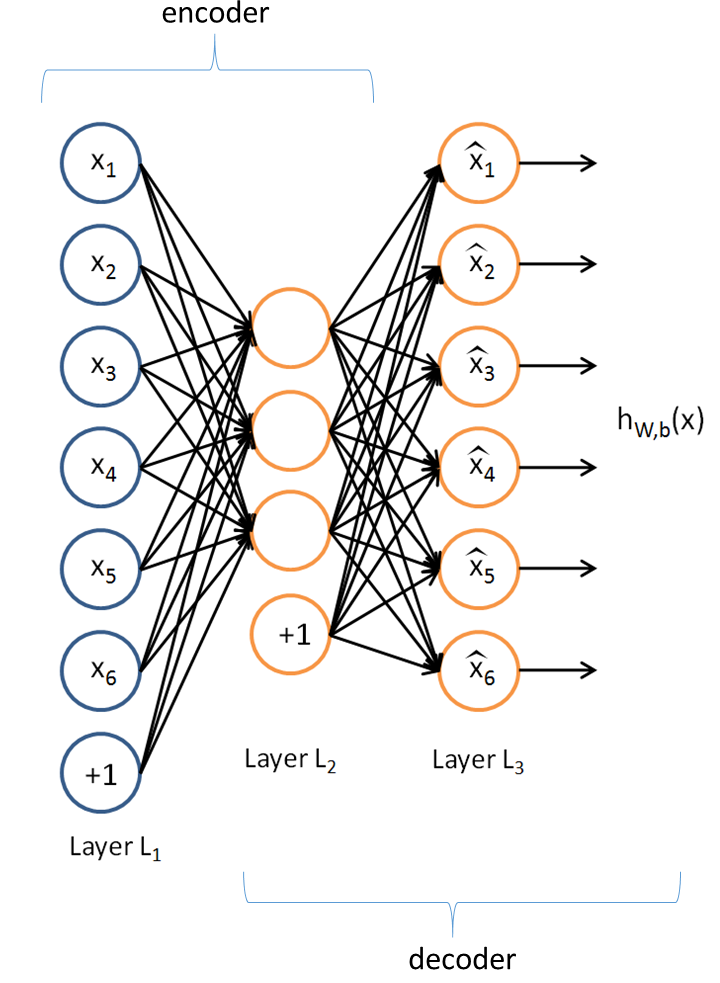

With differentiable nonlinear activation functions in the fully-connected layers, we can use a **gradient descent**-based optimizer to iteratively minimize the reconstruction error of the autoencoder.

### 2.1.1 Autoencoder Implementation

Starting from the code below, write your own implementation of an autoencoder. For the encoder and the decoder, use [`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) to create a chain of [a fully-connected layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) and a [sigmoid layer](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html#torch.nn.Sigmoid). Make sure to pass in the correct arguments to `nn.Linear`.

```python
class Autoencoder(nn.Module):
    def __init__(self, num_input_neurons, num_hidden_neurons):
        super().__init__()
        self.encoder = # sequential of fully-connected and sigmoid
        self.decoder = # sequential of fully-connected and sigmoid

        # Store these for easy access
        self.num_input_neurons = num_input_neurons
        self.num_hidden_neurons = num_hidden_neurons

    def forward(self, x):
        # Encode the input
        z = self.encoder(x)

        # Reconstruct x
        x_pred = self.decoder(z)

        # Return both the encoding and the reconstruction
        return z, x_pred
```

In [ ]:
## Write your autoencoder implementation here ##

### 2.1.2 Training Script for an Autoencoder

Below, we have implemented a variant of the training and validation step you have used multiple times before. To train our autoencoder, we will use a loss that is a **combination of two losses**:

1. The **MSE-loss** measures how different the reconstruction is from the original;
2. The **sparsity** loss is minimized when the encoding $z$ is *sparse*, i.e., contains a lot of zeroes. An autoencoder trained with such a loss term is called a *sparse autoencoder*.

Read through the code below and make sure to understand it.

In [ ]:
def autoencoder_training_step(
    model, x_train,
    sparsity_weight, sparsity_rho,
    optimizer, writer, epoch
):
    """
    Perform a single autoencoder training step

    Args:
        model: The autoencoder.
        x_train: The input training data.
        sparsity_weight: Weight of the sparsity loss in the total loss.
        sparsity_rho: Expected average of the elements in the encoding vector. The
            lower this value, the more sparse you want the encoding to be.
        optimizer: The optimizer.
        writer: `SummaryWriter` object used to log the training loss
            to TensorBoard.
        epoch: The current epoch number.
    """
    z, x_pred  = model(x_train)

    # Compute reconstruction error
    mse_loss = F.mse_loss(x_pred, x_train)

    # Compute sparsity error
    sparsity_loss = sparsity_loss_fn(z, sparsity_rho)

    # Compute total loss
    loss = mse_loss + sparsity_weight * sparsity_loss

    # Backpropagate + optimizer step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Log the training losses
    writer.add_scalar(f"MSE/Train", mse_loss, epoch)
    writer.add_scalar(f"SparsityError/Train", sparsity_loss, epoch)
    writer.add_scalar(f"TotLoss/Train", loss, epoch)

In [ ]:
@torch.no_grad()
def autoencoder_validation_step(
    model, x_val,
    sparsity_weight, sparsity_rho,
    writer, epoch
):
    """
    Compute and log the validation loss.
    
    Args:
        model: The autoencoder.
        x_val: The input validation data.
        sparsity_weight: Weight of the sparsity loss in the total loss.
        sparsity_rho: Expected average of the elements in the encoding vector. The
            lower this value, the more sparse you want the encoding to be.
        writer: `SummaryWriter` object used to log the validation loss
            to TensorBoard.
        epoch: The current epoch number.
    """
    # Pass the validation data through the model
    z, x_pred = model(x_val)

    # Compute reconstruction error
    mse_loss = F.mse_loss(x_pred, x_val)

    # Compute sparsity error
    sparsity_loss = sparsity_loss_fn(z, sparsity_rho)

    # Compute total loss
    loss = mse_loss + sparsity_weight * sparsity_loss

    writer.add_scalar(f"MSE/Val", mse_loss, epoch)
    writer.add_scalar(f"SparsityError/Val", sparsity_loss, epoch)
    writer.add_scalar(f"TotLoss/Val", loss, epoch)

To make your life somewhat easier, we have also implemented a training loop that creates an optimizer and a `SummaryWriter` and iteratively calls `autoencoder_training_step()` and `autoencoder_validation_step()`. Again, make sure you understand the code.

In [ ]:
def train_autoencoder(
    model, x_train, x_val, optimizer,
    sparsity_weight, sparsity_rho,
    num_epochs, log_root
):
    """
    Train an autoencoder.

    Args:
        model: The autoencoder.
        x_train: The input training data.
        x_val: The input validation data.
        optimizer: The optimizer.
        sparsity_weight: Weight of the sparsity loss in the total loss.
        sparsity_rho: Expected average of the elements in the encoding vector. The
            lower this value, the more sparse you want the encoding to be.
        num_epochs: The number of epochs.
        log_root: The root directory of the TensorBoard logs.
    """
    # Create a SummaryWriter instance with a meaningful run name
    run_name = get_ae_run_name(model, sparsity_weight, sparsity_rho, optimizer)
    writer = SummaryWriter(log_dir=f'{log_root}/{run_name}')

    for epoch in tqdm(range(num_epochs)):
        # Run training step
        autoencoder_training_step(
            model, x_train,
            sparsity_weight, sparsity_rho,
            optimizer, writer, epoch
        )

        # Run validation step
        autoencoder_validation_step(
            model, x_val,
            sparsity_weight, sparsity_rho,
            writer, epoch
        )

### 2.1.3 Training an Autoencoder on MNIST

Before we can train our autoencoder, we need training data. Just like in the previous notebook, we will use the MNIST dataset. The function below flattens the MNIST images into vectors and rescales the data between `0.0` and `1.0`.

In [ ]:
def get_mnist(train=True):
    mnist = MNIST(root='data', download=True, train=train)
    data = ((mnist.data.flatten(start_dim=1).float() / 255))

    return data, mnist.targets

We use this function to create our training and validation datasets below.

In [ ]:
mnist_x_train, mnist_y_train = get_mnist(train=True)
mnist_x_val, mnist_y_val = get_mnist(train=False)

We can now go ahead and train the autoencoder with `train_autoencoder()`. We will train the autoencoder for 1000 epochs.

In [ ]:
# Define your model
ae1 = Autoencoder(28 * 28, 100)

# Create an optimizer
optimizer = optim.Adam(
    params=ae1.parameters(),
    lr=0.01,
)

# Train the model on mnist_x_train
train_autoencoder(
    model=ae1, x_train=mnist_x_train, x_val=mnist_x_val,
    optimizer=optimizer,
    sparsity_weight=1.0, sparsity_rho=0.05,
    num_epochs=1000,
    log_root='runs_sae'
)

While you are waiting for this slow training to end, you might wonder if there is no faster way to train. Luckily, **there is**! Feel free to stop your training by interrupting the kernel and read on!

### 2.1.4 Training on GPU

Many of the computations necessary for training a neural network can be highly parallellized. A Graphics Processing Unit (GPU) is designed for performing such computations and is much better suited for training neural networks than a Central Processing Unit (CPU).

PyTorch has built-in support for CUDA, a parallel computing API developed by Nvidia for their GPU hardware. You can easily check that CUDA is available (i.e., the necessary hardware, drivers and libraries are available) by running

```python
torch.cuda.is_available()
```

In [ ]:
torch.cuda.is_available()

A typical oneliner you'll see in PyTorch code is the following:

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

This assigns the value `'cuda'` to the variable `device` when CUDA is available. If CUDA is not available, `device` will get the value `'cpu'`. If a GPU with CUDA support is available, we can move our model `ae1` to GPU with the following line:

In [ ]:
ae1 = ae1.to(device)

*Moving our model to GPU* means that all model parameters (weights and biases) are now stored in GPU memory (instead of in the RAM used by the CPU). All operations with GPU tensors will be performed by the GPU. **It is not allowed to perform operations with tensors that are on different devices** (GPU and CPU). This requires **all our model inputs to also be in GPU memory**, so we should move the data to the GPU as well:

In [ ]:
mnist_x_train = mnist_x_train.to(device)
mnist_y_train = mnist_y_train.to(device)

mnist_x_val = mnist_x_val.to(device)
mnist_y_val = mnist_y_val.to(device)

You can check on which device a tensor lives by simply printing the tensor.

In [ ]:
ae1.encoder[0].weight

Let's run our training script again. You'll see that it runs much faster this time.

In [ ]:
optimizer = optim.Adam(
    params=ae1.parameters(),
    lr=0.01,
)

train_autoencoder(
    model=ae1, x_train=mnist_x_train, x_val=mnist_x_val,
    optimizer=optimizer,
    sparsity_weight=1.0, sparsity_rho=0.05,
    num_epochs=1000, log_root='runs_sae'
)

### 2.1.5 Visualizing the Results

Our encoder contains a single fully-connected layer that transforms the input to a lower dimension. By inspecting the weights of this layer, we can see which patterns the model uses to encode the input. A high value in the first element of the encoding, for example, indicates that the input has a lot of similarities with the first pattern.

In [ ]:
# Get encoder weights
encoder_weights = ae1.encoder[0].weight

# Reshape the weights into images of size 28 x 28
encoder_weights = encoder_weights.unflatten(1, (28, 28))

# Detach the weights from PyTorch autograd and move back to CPU
encoder_weights = encoder_weights.detach().cpu()

# Visualize the weights
show_ims(encoder_weights, columns=10, figsize=(10, 10))

We can do the same for the weights in the fully-connected layer of the decoder. The output of the decoder's fully-connected layer will be a linear combination (+ bias) of these patterns.

In [ ]:
decoder_weights = ae1.decoder[0].weight.T.unflatten(1, (28, 28)).detach().cpu()

show_ims(decoder_weights, columns=10, figsize=(10, 10))

Now, let's see how well our model can compress and reconstruct some validation images.

In [ ]:
with torch.no_grad():
    _, x_pred = ae1(mnist_x_val)

N = 10

show_ims(x_pred.unflatten(1, (28, 28)).detach().cpu()[:N], columns=10, figsize=(10, 2), title="Reconstructions")

In [ ]:
show_ims(mnist_x_val.unflatten(1, (28, 28)).detach().cpu()[:N], columns=10, figsize=(10, 2), title="Originals")

## 2.2 Stacked Autoencoder

A stacked autoencoder is a neural network that consists of multiple layers of autoencoders in which the outputs of each layer are wired to the inputs of the successive layer. The information of interest is contained by the output of the deepest encoding layer. This vector gives us a representation of the input in terms of higher-order features.

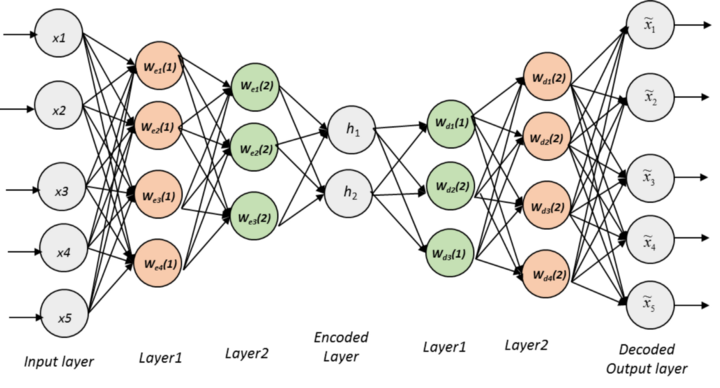

For the use of classification, the common practice is to discard the "decoding" layers of the stacked autoencoder and link the last encoding layer to a classifier, as depicted in the figure below.

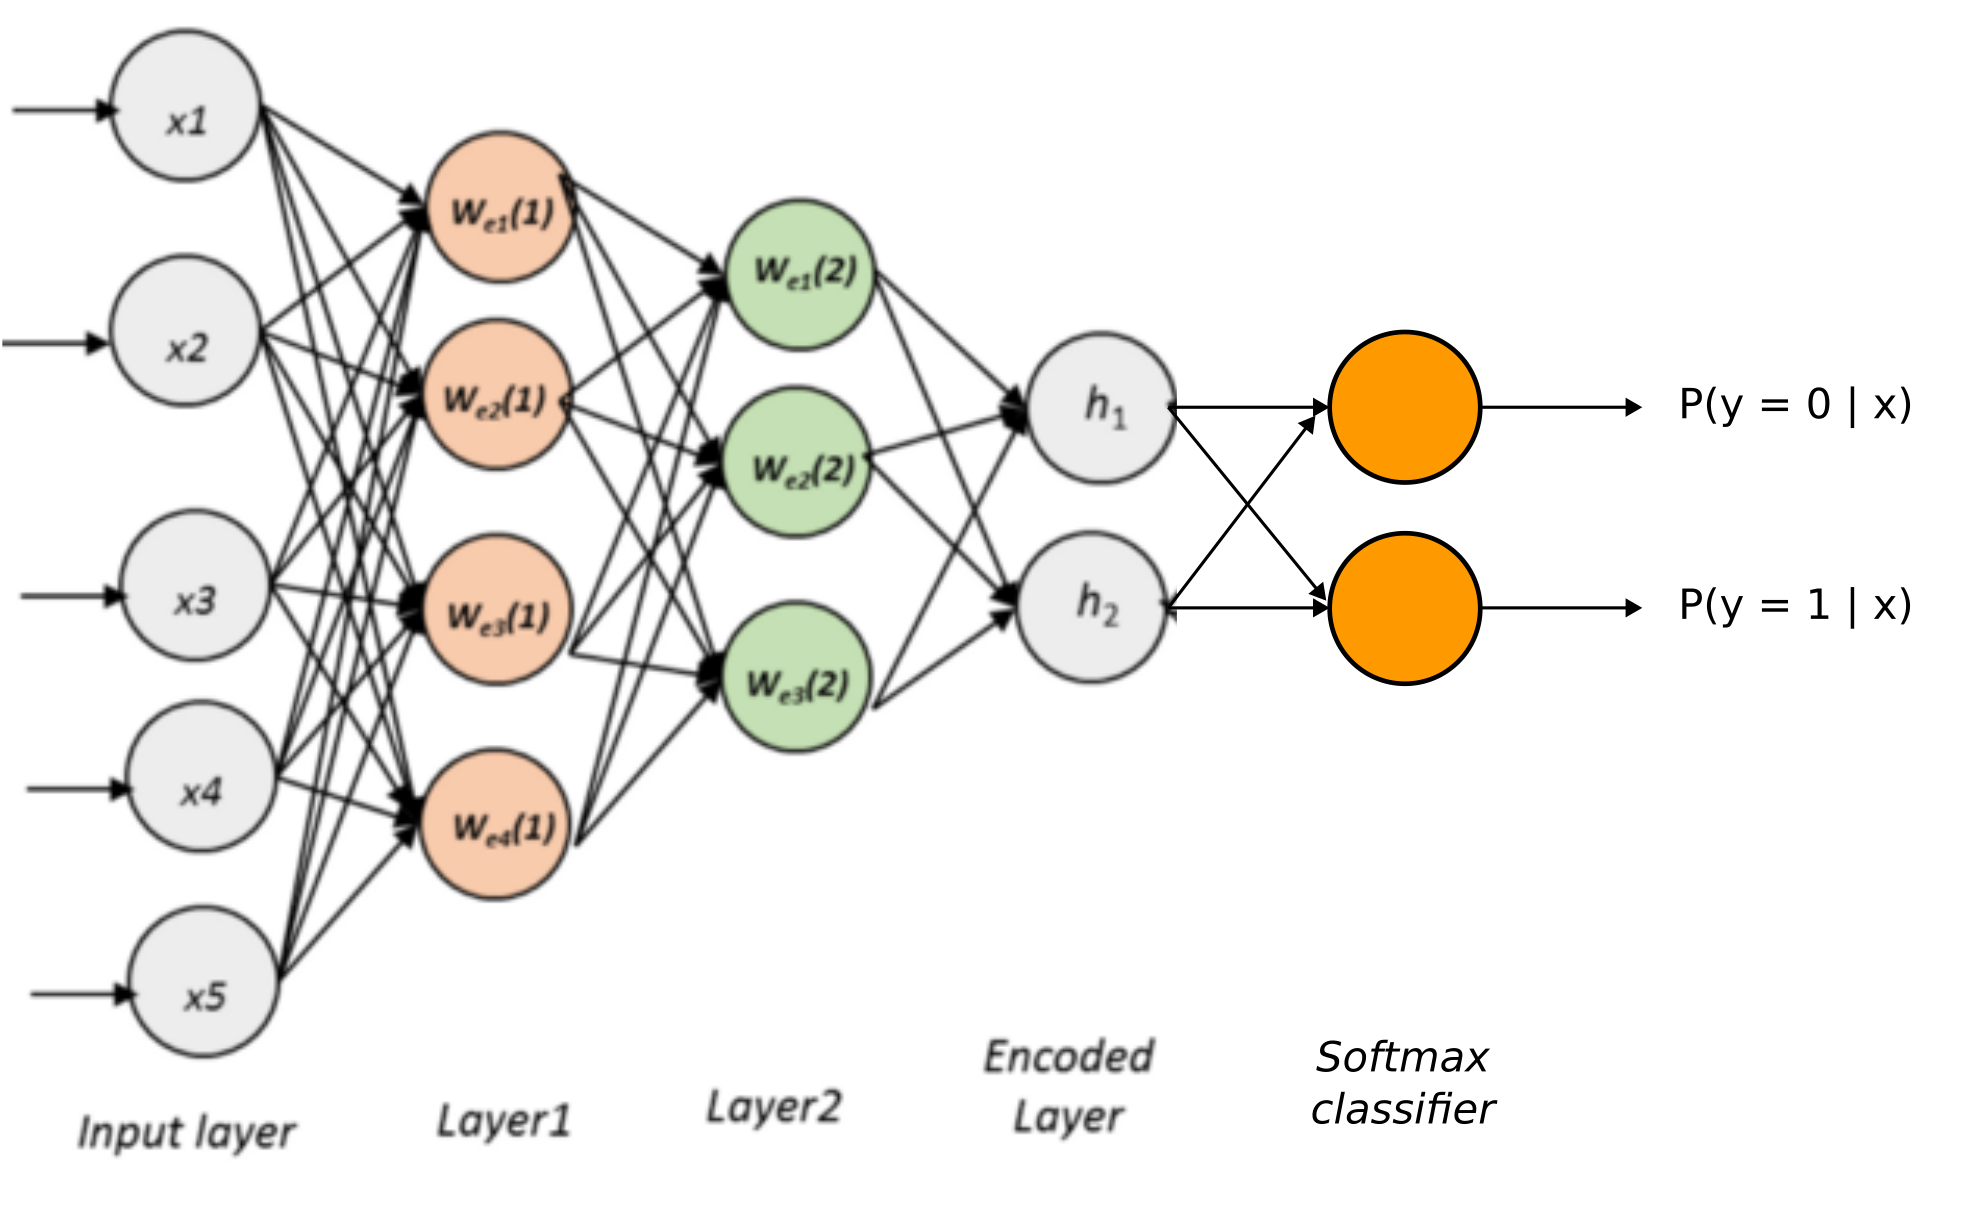

A good way to obtain parameters for a stacked autoencoder is to use *greedy layer-wise training*. We train the first autoencoder on the raw input to obtain the weights and biases from the input to the first hidden layer. Then we use this hidden layer as input to train the second autoencoder to obtain the weights and biases from the first to the second hidden layer. This can be repeated for subsequent layers, using the output of each layer as input for the subsequent layer.

This method trains the parameters of each layer individually while freezing parameters for the remainder of the model. To produce better results, after this phase of training is complete, *fine-tuning* using backpropagation can be used to improve the results by tuning the parameters of all layers at the same time.

### 2.2.1 Greedy Layer-Wise Training

We will use `ae1` as the first autoencoder for the stacked autoencoder. The second autoencoder learns to compress and reconstruct the encodings of `ae1`. So, our training data consists of encodings, not images. To create the training data, we must thus pass all MNIST images through `ae1`.

In [ ]:
with torch.no_grad():
    # Get encodings of MNIST training images
    ae1_encodings_train, _ = ae1(mnist_x_train)

    # Get encodings of MNIST validation images
    ae1_encodings_val, _ = ae1(mnist_x_val)

- Create and train a new autoencoder `ae2` that encodes the `ae1` encodings to a lower dimensionality. Don't forget to move the model to the correct compute device before training.
- Play around with the hyperparameters until you find suitable ones (number of epochs, number of hidden units, the sparsity parameters, learning rate, etc.). Which hyperparameters give the lowest reconstruction error? How do these compare to the hyperparameters we used to train `ae1`?

In [ ]:
## Write your code here ##

We can now use `nn.Sequential` to create a stacked autoencoder of `ae1` and `ae2`.

In [ ]:
sae = nn.Sequential(ae1.encoder, ae2.encoder, ae2.decoder, ae1.decoder)

Let's take a look at the reconstructions produced by the stacked autoencoder for some of the validation images.

In [ ]:
with torch.no_grad():
    x_pred = sae(mnist_x_val)

N = 10

show_ims(x_pred.unflatten(1, (28, 28)).detach().cpu()[:N], columns=10, figsize=(10, 10))

### 2.2.2 Training a Classifier on Stacked Autoencoder Features

The encodings produced by `ae2` are abstract vector representations of the respective input images. The autoencoders were trained in such a way that these lower-dimensional vector representations were sufficient to reconstruct the input images as well as possible. As such, these vectors, called *deep features*, contain essential information about the input and we can employ them for **learning downstream tasks**, like classification.

In this section, we train a classifier to classify the encodings from `ae2` into the corresponding classes (i.e., digit 0 to 9). Below, we have already implemented a function for training a classifier.

In [ ]:
def train_classifier(model, x_train, y_train, x_val, y_val, optimizer, num_epochs, log_root):
    """
    Train a classifier.

    Args:
        model: The classification model.
        x_train: The input training data.
        y_train: The ground-truth classes of the training data.
        x_val: The input validation data.
        y_val: The ground-truth classes the validation data.
        optimizer: The optimizer.
        num_epochs: The number of epochs.
        log_root: The root directory of the TensorBoard logs.
    """
    # Define loss function
    loss_fn = nn.CrossEntropyLoss()

    # Create SummaryWriter with a meaningful name
    run_name = get_clf_run_name(model, optimizer)
    writer = SummaryWriter(log_dir=f'{log_root}/{run_name}')

    # Iterate over the epochs
    for epoch in tqdm(range(num_epochs)):
        y_pred = model(x_train)

        # Compute loss
        loss = loss_fn(y_pred, y_train)

        # Backpropagate + optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Log loss
        writer.add_scalar(f"{loss_fn.__class__.__name__}/Train", loss, epoch)

        # Validation
        with torch.no_grad():
            y_pred = model(x_val)

            # Compute loss
            loss = loss_fn(y_pred, y_val)

            # Compute accuracy
            acc = (y_val == y_pred.argmax(dim=1)).float().mean()

        # Log validation loss and accuracy
        writer.add_scalar(f"{loss_fn.__class__.__name__}/Val", loss, epoch)
        writer.add_scalar("Accuracy/Val", acc, epoch)

You can use a fully-connected layer to create a simple classification model that outputs unnormalized class logits:

```python
clf = nn.Linear(
    feature_dim,
    num_classes
)
```

where `feature_dim` contains the dimensionality of the feature vectors and `num_classes` is the number of classes. Such a model can be trained with [`nn.CrossEntropyLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). When passed through a [`nn.Softmax()`](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) layer, the class logits of a sample can be normalized to a valid probability mass function over the classes (i.e., all elements are between 0 and 1 and the sum of all elements equals 1).

- Create a classifier `clf` that outputs class logits for the encodings of `ae2`.
- Create the input training and validation dataset.
- Use the function `train_classifier()` (defined above) to train the classifier. Use `mnist_y_train` and `mnist_y_val` for `y_train` and `y_val`, respectively. Play around with the hyperparameters to find out which values yield the best validation performance.

In [ ]:
## Write your code here ##

The accuracy of the model is logged by `train_classifier()` to TensorBoard. To get a more detailed view on the classification performance, we can create a **confusion matrix**. By definition a confusion matrix $C$ is such that the element $c_{i, j}$ in row $i$ and column $j$ is equal to the number of inputs that have ground-truth class $i$ and were predicted to have class $j$. For a perfect model, the confusion matrix is zero everywhere, except on the diagonal.

To create a confusion matrix, we first need the class predictions of the validation data. As our model outputs class probabilities, we need to apply `argmax()` to obtain the index (read: class) of the element with the largest value.

In [ ]:
with torch.no_grad():
    # Compute class probabilities of each sample
    y_pred = clf(ae2_encodings_val)

# For each sample, get the class with the highest probability
y_pred = y_pred.argmax(dim=1)

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(mnist_y_val.cpu(), y_pred.cpu())

# Show the confusion matrix
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

### 2.2.3 Finetuning

To improve the classifier, we can *finetune* the model parameters by training the classifier (with the encoders) end-to-end for some epochs.

- Combine the encoders and the classifier into a single model with `nn.Sequential()`
- Use `train_classifier()` to finetune this new classifier

In [ ]:
## Write your code here ##

## 2.3 Exercise

- Compare the patterns of the encoder and the decoder of `ae1` (see section 2.1.5). What do you notice? Can you explain this?
- Use greedy layer-wise training to train deeper stacked autoencoders. For each of these stacked autoencoders, train a classifier on the deepest encodings. Investigate the influence of multiple hyperparameters (number of layers, number of hidden neurons in each layer, number of epochs,...) on both the reconstruction quality and the classification performance.
- For each stacked autoencoder, use `nn.Sequential` and `nn.Linear` to create an MLP with the same number of layers and hidden neurons as the autoencoder. Train it with `train_classifier()` on the MNIST dataset. Compare the results with the greedy layer-wise training.
- What can you tell about the effect of finetuning? Explain *why* and *how* this affects the performance.